In [ ]:
%%rqalpha_plus -s 20160301 -e 20160901 --account future 1000000 -fq 1m -p 
# 上述命令参数可以通过运行 %%rqalpha_plus -h 查看到
 
# 可以自己import我们平台支持的第三方python模块，比如pandas、numpy等。
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):
    # context内引入全局变量s1
    context.pairs = ["AU","AG"]
    context.observed_periods1 = 300
    
    context.over_up_point = False
    context.under_low_point = False
    context.observed_periods2 = 60
    context.bar_count = 0
    
    context.entry_multiply = 2
    
    # context.ratio = 15
    
    # 订阅连续主力
    subscribe([i +"88" for i in context.pairs])
    # 实时打印日志

# before_trading此函数会在每天策略交易开始前被调用，当天只会被调用一次
def before_trading(context):
    context.bar_count = 0
    # 计算对冲比例
    # context.ratio
    calc_pairs_ratio(context)
    # 日内不会更换主力，因此在交易前判断是否更换主力
    # 最新主力保留在 context.latest_futures
    change_symbol(context)

def check(context,bar_dict):
    
    item1,item2 = context.latest_futures
    
    positions_item1 = context.portfolio.positions[item1]
    positions_item2 = context.portfolio.positions[item2]
    # calculate the spread of items
    _price1 = history_bars(item1,context.observed_periods2,'1m','close')
    _price2 = history_bars(item2,context.observed_periods2,'1m','close')
    
    _spread = _price2 - context.ratio * _price1
    _spread_std = _spread.std()
    _spread_mean = _spread.mean()
    
    up_point = _spread_mean + context.entry_multiply * _spread_std
    low_point = _spread_mean - context.entry_multiply * _spread_std
    
    cur_price_1 = bar_dict[item1].close
    cur_price_2 = bar_dict[item2].close
    _cur_spread = cur_price_2 - context.ratio * cur_price_1
    
    print(up_point,low_point,_cur_spread)
    
    # 价差低于下限，建仓
    # item2 价低，item1价高
    if (not context.under_low_point) and _cur_spread <= low_point:
        bqt_item2_remain = 1-positions_item2.buy_quantity
        sqt_item1_remain = context.ratio - positions_item1.sell_quantity
#         print("创建买入价差")
        if bqt_item2_remain > 0:
            buy_open(item2,bqt_item2_remain)
        if sqt_item1_remain > 0:
            sell_open(item1,sqt_item1_remain)
        if bqt_item2_remain == 0 and sqt_item1_remain == 0:
            context.under_low_point = True
    if context.under_low_point and _cur_spread >= _spread_mean:
#         print("对买入价差进行平仓")
        bqt_item2_remain = positions_item2.buy_quantity
        sqt_item1_remain = positions_item1.sell_quantity
        
        if bqt_item2_remain>0:
            sell_close(item2,bqt_item2_remain)
        if sqt_item1_remain>0:
            buy_close(item1,sqt_item1_remain)
        if bqt_item2_remain == 0 and sqt_item1_remain == 0:
            context.under_low_point = False
            
            # item2价高，item1价低
    if (not context.over_up_point) and _cur_spread >= up_point:
#         print("创建卖出价差")
        bqt_item1_remain = context.ratio - positions_item1.buy_quantity
        sqt_item2_remain = 1-positions_item2.sell_quantity
        
        if bqt_item1_remain>0:
            buy_open(item1,bqt_item1_remain)
        if sqt_item2_remain>0:
            sell_open(item2,sqt_item2_remain)
        if bqt_item1_remain == 0 and sqt_item2_remain == 0:
            context.over_up_point = True
    if context.over_up_point and _cur_spread < _spread_mean:
#         print("价差平仓")
        bqt_item1_remain = positions_item1.buy_quantity
        sqt_item2_remain = positions_item2.sell_quantity
        if bqt_item1_remain>0:
            sell_close(item1,bqt_item1_remain)
        if sqt_item2_remain>0:
            buy_close(item2,sqt_item2_remain)
        if bqt_item1_remain == 0 and sqt_item2_remain == 0:
            context.over_up_point = False
        
    

# 你选择的期货数据更新将会触发此段逻辑，例如日线或分钟线更新
def handle_bar(context, bar_dict):
    # 开始编写你的主要的算法逻辑
    # bar_dict[order_book_id] 可以获取到当前期货合约的bar信息
    # context.portfolio 可以获取到当前投资组合信息
    # 使用buy_open(id_or_ins, amount)方法进行买入开仓操作
    context.bar_count+=1
    
    if context.bar_count>context.observed_periods2:
        check(context,bar_dict)
    
# after_trading函数会在每天交易结束后被调用，当天只会被调用一次
def after_trading(context):
    pass


def calc_pairs_ratio(context):
    pairsx = [i+"88" for i in context.pairs]
    item1_x,item2_x = pairsx
    _price1 = history_bars(item1_x,context.observed_periods1,'1d','close')
    _price2 = history_bars(item2_x,context.observed_periods1,'1d','close')
    
    _lenx = min(len(_price1),len(_price2))
    _price1 = _price1[-_lenx:]
    _price2 = _price2[-_lenx:]
    
        
    linreg = LinearRegression(fit_intercept = True)
    context.ratio = linreg.fit(_price1.reshape(-1,1),_price2).coef_[0]
    context.ratio = int(context.ratio)
    context.ratio = 15
    
    
    
    
def change_symbol(context):
    # 当前持有的期货代码
    cur_positions = context.portfolio.positions
    
    # 最新的主力期货代码
    latest_futures = [get_dominant_future(code) for code in context.pairs]
    context.latest_futures = latest_futures
    # 订阅行情
    subscribe(context.latest_futures)
    print(context.latest_futures)
    
    # 需要平仓的
    to_close = sorted(set(cur_positions)-set(latest_futures))
    
    if len(to_close) == 0:
#         logger.info("没有需要强制平仓的期货")
        pass
    else:
        for _s in to_close:
            _positions = context.portfolio.positions[_s]
            _bqt = _positions.buy_quantity
            _sqt = _positions.sell_quantity
            try:
                if _bqt>0:
                    clear_long(context,_s)
                if _sqt>0:
                    clear_short(context,_s)
            except Exception as e:
                print("强制平仓失败>>%s"%(str(e)))
            print("成功更换主力")
    
def clear_long(context,s):
    _done = False
    while not _done:
        _quantity = context.portfolio.positions[s].buy_quantity
        
        if _quantity == 0:
            _done = True
        else:
            sell_close(s,_quantity)
    
def clear_short(context,s):
    _done = False
    while not _done:
        _quantity = context.portfolio.positions[s].sell_quantity
        
        if _quantity == 0:
            _done = True
        else:
            buy_close(s,_quantity)
    
    
    
    
    
    
    
    

[2018-03-24 15:32:32.535342] INFO: system_log: rqdatac use socket ('q-rqdatad', 16003)
2016-02-29 20:31:00.00 INFO ['AU1606', 'AG1606']
2016-02-29 22:01:00.00 INFO -571.964664549 -580.568668785 -580.75
2016-02-29 22:02:00.00 INFO -571.940338277 -580.867995056 -581.75
2016-02-29 22:03:00.00 INFO -572.078832413 -581.012834254 -580.75
2016-02-29 22:04:00.00 INFO -572.063733837 -581.419599496 -583.75
2016-02-29 22:05:00.00 INFO -572.23620273 -581.605463937 -582.25
2016-02-29 22:06:00.00 INFO -572.18547768 -581.931188987 -582.75
2016-02-29 22:07:00.00 INFO -571.999330161 -582.367336505 -584.0
2016-02-29 22:08:00.00 INFO -571.875 -582.775 -584.0
2016-02-29 22:09:00.00 INFO -571.829446479 -583.245553521 -585.5
2016-02-29 22:10:00.00 INFO -571.707419155 -583.767580845 -586.0
2016-02-29 22:11:00.00 INFO -571.691215364 -584.117117969 -584.5
2016-02-29 22:12:00.00 INFO -571.815266779 -584.268066554 -582.25
2016-02-29 22:13:00.00 INFO -571.922172366 -584.419494301 -582.25
2016-02-29 22:14:00.00 IN

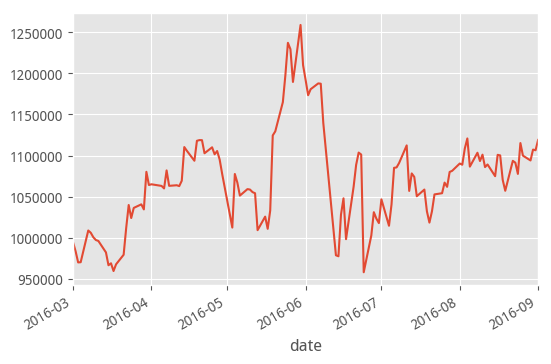

In [10]:
results['sys_analyser']['portfolio'].total_value.plot()